# MDL DB roll decay content
What is the data in the roll decay database and roll damping database?

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

import data
import copy
from mdldb.mdl_db import MDLDataBase
from mdldb.tables import Base, Model, LoadingCondition, Run, RolldecayLinear, RolldecayDirect, RolldecayNorwegian
from mdldb.tables import Min, Mean, Max, Std, Ship
from mdldb import mdl_to_evaluation
from evaluation.run_dynamic import RunDynamic
from evaluation.run_manoeuvring import RunZigZag

from rolldecayestimators.direct_estimator import DirectEstimator
from rolldecayestimators.direct_linear_estimator import DirectLinearEstimator
from rolldecayestimators.norwegian_estimator import NorwegianEstimator
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
#from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from sklearn.pipeline import Pipeline

import signal_lab
from sqlalchemy.inspection import inspect
import seaborn as sns
import docs

c:\dev\rolldecay\venv\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///' + data.mdl_db_path)
db = MDLDataBase(engine=engine)

In [4]:
roll_decay_tests = db.session.query(Run).filter((Run.id==Min.run_id) & 
                                                (Run.test_type=='roll decay'))

In [5]:
len(roll_decay_tests.all())

407

In [6]:
ships = db.session.query(Ship).filter((Run.id==Min.run_id) & 
                                                (Run.test_type=='roll decay'))

In [7]:
df_ships = pd.DataFrame()

for ship in ships:
    instance = inspect(ship)
    
    s = pd.Series()
                
    for key,item in instance.attrs.items():
        if not isinstance(item.value, list):
            if pd.notnull(item.value):
                s[key]=item.value
    
    df_ships = df_ships.append(s, ignore_index=True)

In [8]:
mask = df_ships[['lpp','beam','BKL','BKB']].notnull().all(axis=1)
df_ships = df_ships.loc[mask].copy()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13D97050>,
      dtype=object)

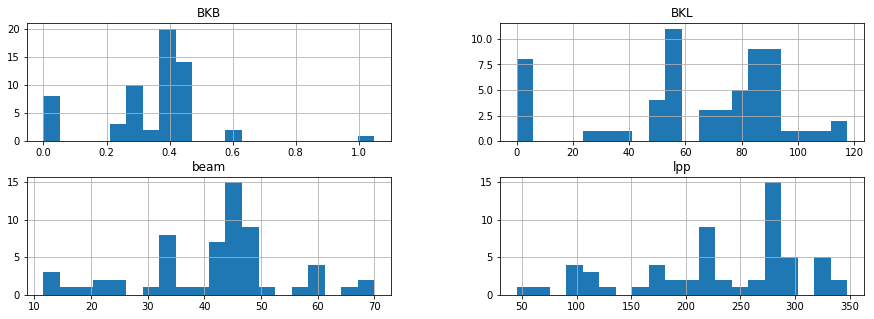

In [9]:
df_ships.hist(column = ['lpp','beam','BKL','BKB'],bins=20)

In [10]:
roll_decay_test = roll_decay_tests[0]

In [11]:
tables = ['min','mean','max','std']
statistics = {}
for table in tables:
    statistics[table] = pd.read_sql_table(table_name=table, con=engine)

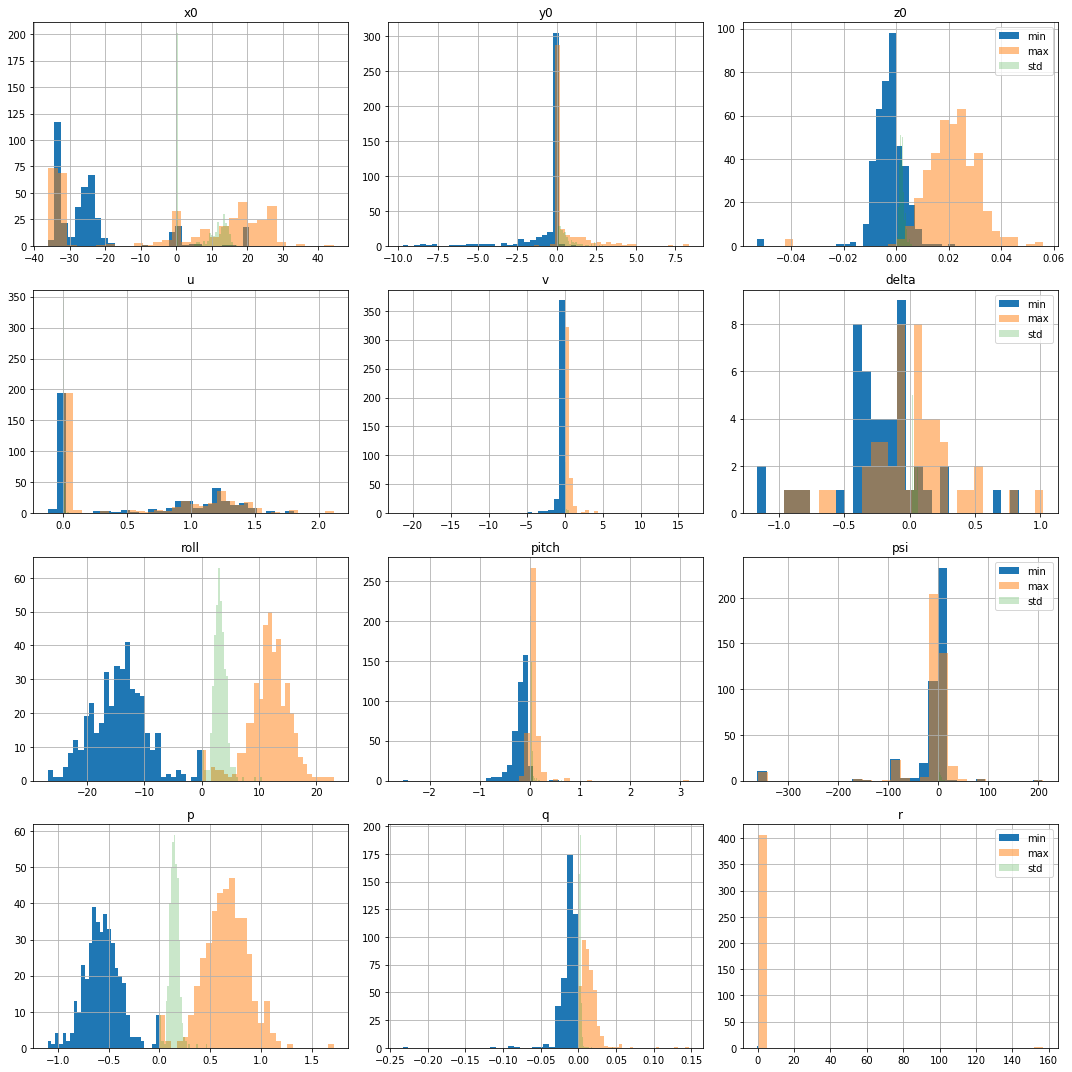

In [12]:
plots = [['x0','y0','z0'],
         ['u','v','delta'],
         ['roll','pitch','psi'],
         ['p','q','r']]
nrows = len(plots)
ncols = 0
for subplots in plots:
    if len(subplots) > ncols:
        ncols = len(subplots)

fig,axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(15,15)

for row, subplots in enumerate(plots):
    for col, plot in enumerate(subplots):
        
        ax = axes[row,col]
        min = statistics['min']
        max = statistics['max']
        std = statistics['std']
        
        bins = 30
        min[plot].hist(label='min', bins=bins, ax=ax)
        max[plot].hist(label='max', bins=bins, ax=ax, alpha=0.5)
        std[plot].hist(label='std', bins=bins, ax=ax, alpha=0.25)
        
        
        ax.set_title(plot)

    ax.legend()
plt.tight_layout()

### Comments
* All values above are in model scale. 
* Speed up to 2 m/s in model scale
* Rudder angle ($\delta$) is not used during test, but can have fixed initial angle to keep the model on a straight course.
* Max roll can be up to 25 degrees!
* The pitch is static (no standard deviation) so it is basically trim due to speed
* p, q and r are rotational velocities for roll, pitch and yaw.


In [13]:
cols = ['roll','psi','u','r']
min[cols].describe()

,roll,psi,u,r
count,407.000000,407.000000,407.000000,407.000000
mean,-14.354498,-17.665514,0.550688,-0.018214
std,4.852812,61.347784,0.603502,0.011007
min,-26.860000,-361.619797,-0.122843,-0.067245
25%,-17.305000,-4.765744,-0.013846,-0.023998
50%,-14.160000,-0.719400,0.279571,-0.016032
75%,-11.415000,-0.032600,1.174762,-0.009942
max,0.005000,207.702791,2.018690,-0.002182


In [14]:
max[cols].describe()

,roll,psi,u,r
count,407.000000,407.000000,407.000000,407.000000
mean,11.733146,-10.616949,0.594980,0.406797
std,3.665115,60.102102,0.613089,7.785212
min,0.000900,-360.046997,0.002522,0.002182
25%,9.965000,-0.057686,0.012196,0.010908
50%,11.980000,0.734857,0.301464,0.017964
75%,14.070000,2.925701,1.216718,0.028362
max,23.000000,210.517791,2.117975,157.081401


In [15]:
std[cols].describe()

,roll,psi,u,r
count,406.000000,407.000000,407.000000,407.000000
mean,3.098627,1.740753,0.006957,0.012714
std,1.154276,2.450445,0.013807,0.153974
min,0.000191,0.002432,0.000956,0.000230
25%,2.433426,0.250915,0.002915,0.002489
50%,3.031317,0.656507,0.004814,0.004314
75%,3.732001,2.077588,0.007300,0.006954
max,10.478363,13.044742,0.232787,3.110646


In [16]:
rolldecay_linear = pd.read_sql_table(table_name='rolldecay_linear', con=engine, index_col='run_id')
rolldecay_direct = pd.read_sql_table(table_name='rolldecay_direct', con=engine, index_col='run_id')
rolldecay_norwegian = pd.read_sql_table(table_name='rolldecay_norwegian', con=engine, index_col='run_id')
rolldecay_direct_improved = pd.read_sql_table(table_name='rolldecay_direct_improved', con=engine, index_col='run_id')


def remove_outliers(df, abs_percentile=0.01, min_score=0.97):
    mask1 = ((df.quantile(abs_percentile) < df) &
            (df < df.quantile(1-abs_percentile)) 
           )
    
    mask2 = df['score'] >= min_score
    return df[mask1].loc[mask2].copy()

rolldecay_linear = remove_outliers(rolldecay_linear)
rolldecay_direct = remove_outliers(rolldecay_direct)
rolldecay_norwegian = remove_outliers(rolldecay_norwegian)
rolldecay_direct_improved = remove_outliers(rolldecay_direct_improved)


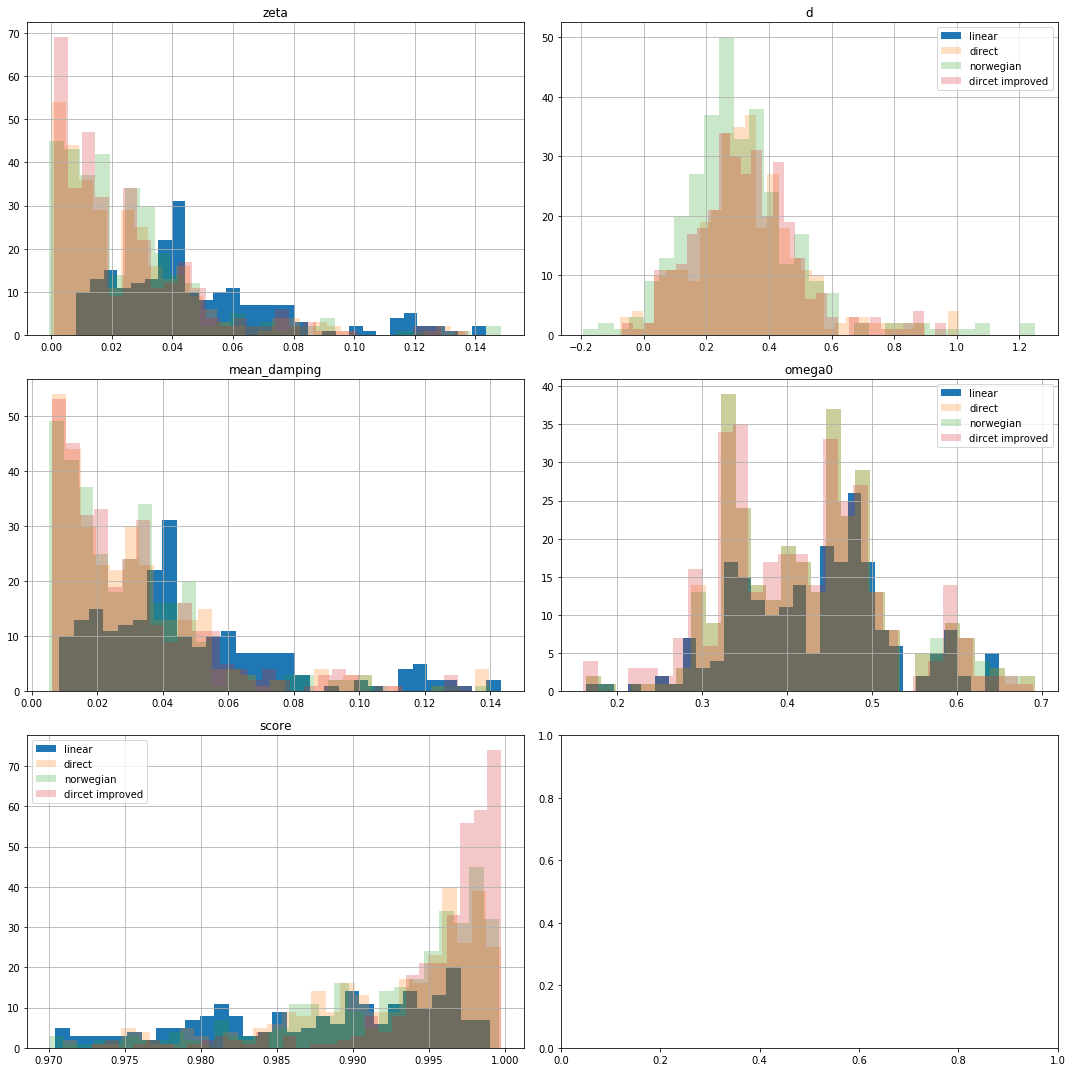

In [17]:
plots = [['zeta','d'],
         ['mean_damping','omega0'],
         ['score'],
        ]
nrows = len(plots)
ncols = 0
for subplots in plots:
    if len(subplots) > ncols:
        ncols = len(subplots)

fig,axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(15,15)

for row, subplots in enumerate(plots):
    for col, plot in enumerate(subplots):
        
        ax = axes[row,col]
        
        bins = 30
        rolldecay_linear[plot].hist(label='linear', bins=bins, ax=ax)
        rolldecay_direct[plot].hist(label='direct', bins=bins, ax=ax, alpha=0.25)
        rolldecay_norwegian[plot].hist(label='norwegian', bins=bins, ax=ax, alpha=0.25)
        rolldecay_direct_improved[plot].hist(label='dircet improved', bins=bins, ax=ax, alpha=0.25)
        
        
        ax.set_title(plot)

    ax.legend()
plt.tight_layout()

<Figure size 1080x360 with 0 Axes>

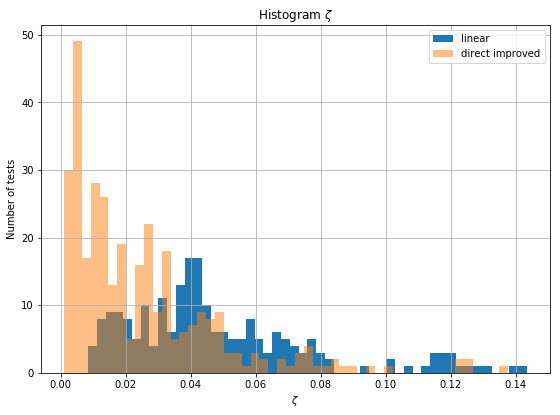

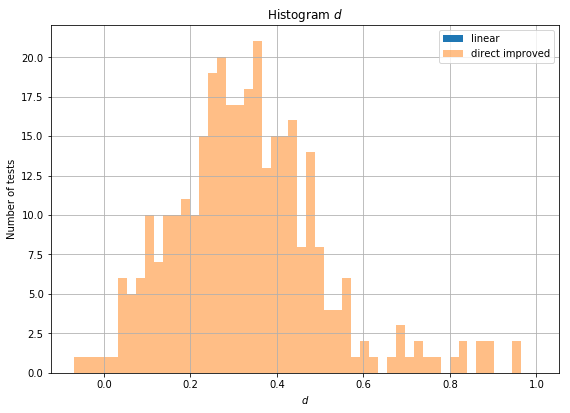

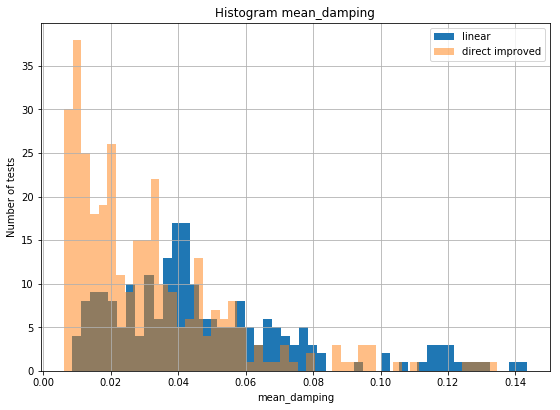

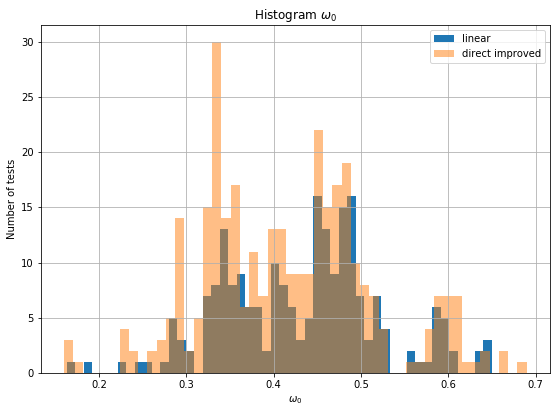

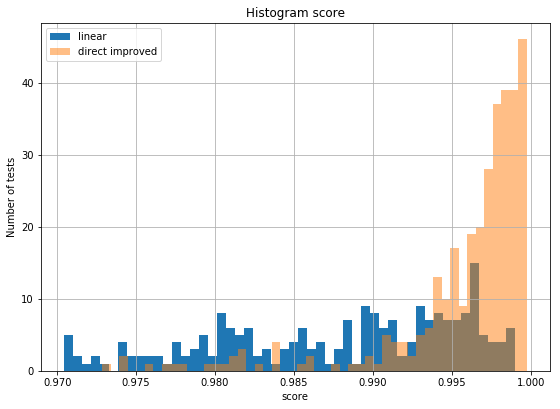

In [18]:
plots= ['zeta','d','mean_damping','omega0','score']

labels = {
    'zeta':'$\zeta$',
    'd':'$d$',
    'omega0':'$\omega_0$',
}

plt.tight_layout()

for plot in plots:
    
    fig,ax = plt.subplots()
    fig.set_size_inches(1.6*np.array([5.7, 4.0]))
       
    bins = 50
    rolldecay_linear[plot].hist(label='linear', bins=bins, ax=ax)
    rolldecay_direct_improved[plot].hist(label='direct improved', bins=bins, ax=ax, alpha=0.5)    
    label = labels.get(plot,plot)
    ax.set_title('Histogram %s' % label)
    ax.set_xlabel(label)
    ax.set_ylabel('Number of tests')
    ax.legend();
    
    file_name = 'histogram_%s.png' % plot
    save_path = os.path.join(docs.path_presentation1,file_name)
    fig.savefig(save_path,transparent=True, dpi=100, bbox_inches='tight')


### Comments

So we now know that mean_damping is in the range 0-0.15...

In [19]:
rolldecay_linear.describe()

,d,mean_damping,omega0,score,zeta
count,0.0,217.000000,219.000000,219.000000,217.000000
mean,NaN,0.048195,0.433172,0.987827,0.048195
std,NaN,0.028898,0.089450,0.007738,0.028898
min,NaN,0.008367,0.163535,0.970429,0.008367
25%,NaN,0.028175,0.359733,0.981461,0.028175
50%,NaN,0.041762,0.447844,0.989724,0.041762
75%,NaN,0.060760,0.486179,0.994641,0.060760
max,NaN,0.143350,0.649662,0.998985,0.143350


In [20]:
rolldecay_direct.describe()

,d,mean_damping,omega0,score,zeta
count,315.000000,312.000000,314.000000,313.000000,312.000000
mean,0.336114,0.030990,0.425872,0.992477,0.024451
std,0.182861,0.024912,0.094370,0.006329,0.023360
min,-0.074307,0.006136,0.163377,0.970944,0.000324
25%,0.234850,0.012499,0.347272,0.989030,0.006751
50%,0.319487,0.025213,0.428230,0.994795,0.017383
75%,0.428426,0.040858,0.484027,0.997389,0.032857
max,1.008231,0.139697,0.692322,0.999717,0.136445


In [21]:
rolldecay_norwegian.describe()

,d,mean_damping,omega0,score,zeta
count,318.000000,317.000000,318.000000,317.000000,319.000000
mean,0.313011,0.029739,0.429298,0.992524,0.024789
std,0.202679,0.022531,0.096513,0.006674,0.023462
min,-0.192577,0.005408,0.163377,0.970060,-0.000511
25%,0.196946,0.012683,0.348426,0.988973,0.008140
50%,0.284463,0.025013,0.431966,0.995096,0.018302
75%,0.391115,0.038974,0.486371,0.997597,0.032263
max,1.250149,0.139938,0.692322,0.999614,0.148451


In [22]:
rolldecay_direct_improved.describe()

,d,mean_damping,omega0,dGM,score,zeta
count,332.000000,330.000000,330.000000,332.000000,332.000000,331.000000
mean,0.332449,0.030608,0.416073,0.085288,0.995838,0.024744
std,0.174124,0.023813,0.097763,0.281863,0.004856,0.023800
min,-0.069580,0.006130,0.160194,-0.743202,0.972848,0.000957
25%,0.225857,0.012416,0.338736,0.011451,0.995151,0.006904
50%,0.320596,0.023589,0.411941,0.080549,0.997482,0.017577
75%,0.425874,0.039717,0.477691,0.156542,0.998677,0.032924
max,0.964880,0.134448,0.689777,2.858157,0.999739,0.137707


c:\dev\rolldecay\venv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """
c:\dev\rolldecay\venv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  
c:\dev\rolldecay\venv\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

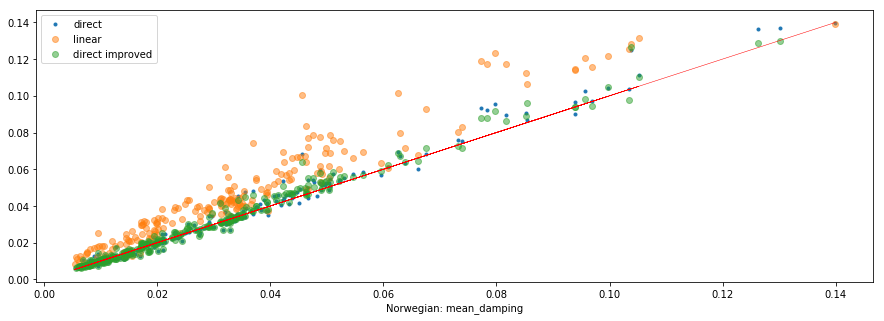

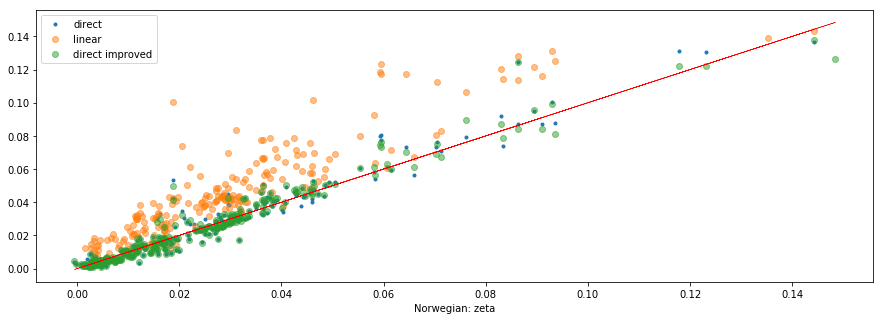

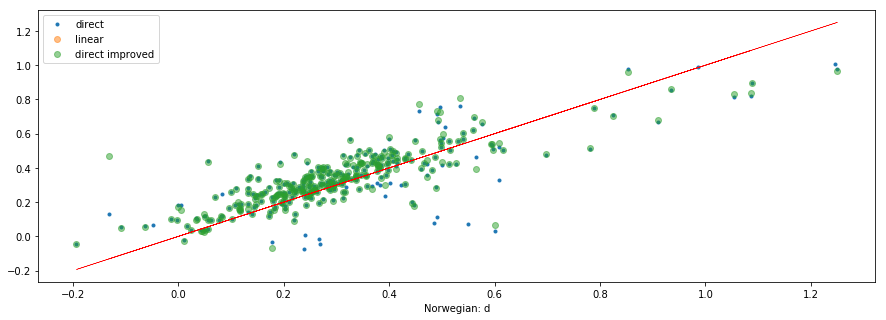

In [23]:
for key in ['mean_damping','zeta','d']:
    
    fig,ax = plt.subplots()
    x = rolldecay_norwegian[key]
    y = rolldecay_direct.loc[rolldecay_norwegian.index][key]
    y2 = rolldecay_linear.loc[rolldecay_norwegian.index][key]    
    y3 = rolldecay_direct_improved.loc[rolldecay_norwegian.index][key]
    
    ax.plot(x,y,'.', label='direct')
    ax.plot(x,y2,'o', label='linear', alpha=0.5)
    ax.plot(x,y3,'o', label='direct improved', alpha=0.5)
    
    ax.set_xlabel('Norwegian: %s' % key)
    ax.legend();
    ax.plot(x,x,'r-')
    


### Comments
* Norwegian method and direct method give differnet results which is not very satisfying.
* Linear method gives higher mean damping, which is a bit strange.

In [24]:
sql="""
SELECT * from
rolldecay_norwegian
INNER JOIN run
ON rolldecay_norwegian.run_id == run.id
    INNER JOIN loading_conditions
    ON (run.loading_condition_id == loading_conditions.id)
        INNER JOIN models
        ON run.model_number == models.model_number
            INNER JOIN ships
            ON models.ship_name == ships.name

"""
df_rolldecay = pd.read_sql(sql, con=engine, index_col='run_id',)
df_rolldecay = df_rolldecay.loc[:,~df_rolldecay.columns.duplicated()]
df_rolldecay = remove_outliers(df_rolldecay)
df_rolldecay.describe()

,d,mean_damping,omega0,score,zeta,id,project_number,series_number,run_number,test_number,loading_condition_id,ship_speed,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,PDTDES,RTYPE,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,HSKEG,RSKEG,LOA,ship_type_id
count,318.000000,317.000000,318.000000,317.000000,319.000000,313.000000,3.100000e+02,308.000000,308.000000,0.0,309.000000,310.000000,305.000000,309.000000,310.000000,206.000000,308.000000,313.000000,210.000000,220.000000,220.000000,151.000000,205.000000,308.000000,219.000000,221.000000,307.000000,287.000000,300.000000,128.000000,219.000000,0.0,93.000000,211.000000,157.000000,155.000000,207.000000,110.000000,199.000000,221.000000,202.000000,199.00000,0.0,217.000000,150.000000,17.000000,144.000000,191.000000,227.000000,0.0,0.0,89.0,0.0,139.000000,154.000000,138.000000,213.000000,141.000000
mean,0.313011,0.029739,0.429298,0.992524,0.024789,11589.041534,2.083606e+07,11.275974,22.240260,NaN,88.977346,8.364194,0.996502,13.153547,5.320800,0.855592,10.160617,10.263163,39.855429,14.855909,58.545773,2.652596,0.764264,81635.821429,0.988000,8.926787,48.017026,229.781359,38.193733,36.966406,2.613653,NaN,8.522151,18.006777,10.313121,128.684516,0.888197,12.079455,16556.854271,1.226244,74.181782,0.39891,NaN,7.066820,28.765333,3.048471,-110.177083,88.476963,54.093018,NaN,NaN,1.0,NaN,-126.985791,7.905649,19.209420,247.002300,4.446809
std,0.202679,0.022531,0.096513,0.006674,0.023462,6022.988872,2.926423e+06,19.275944,11.907929,NaN,44.301536,7.513210,6.319170,3.897391,3.732366,0.032785,3.601393,3.518347,10.222644,4.323486,15.976571,0.813573,0.040484,54518.121386,0.018385,2.835605,11.888293,68.847415,10.947567,16.368677,9.123432,NaN,1.045226,2.235849,2.617155,42.104075,0.108065,4.360540,7509.421741,0.634922,19.884552,0.08233,NaN,1.727427,6.186562,0.281830,21.672766,25.205972,31.383418,NaN,NaN,0.0,NaN,23.695249,1.177021,11.964125,66.925394,1.333232
min,-0.192577,0.005408,0.163377,0.970060,-0.000511,572.000000,2.005403e+07,1.000000,3.000000,NaN,3.000000,0.200000,-10.848900,4.980000,0.570000,0.769000,3.900000,3.150000,14.000000,4.990000,16.050000,0.570000,0.632500,817.000000,0.883000,3.000000,16.000000,85.000000,14.000000,5.100000,-11.680000,NaN,5.400000,14.000000,5.500000,44.600000,0.700000,6.800000,2235.000000,1.000000,24.190000,0.25000,NaN,2.500000,14.000000,2.650000,-139.500000,66.400000,5.550000,NaN,NaN,1.0,NaN,-151.000000,5.900000,1.100000,70.500000,3.000000
25%,0.196946,0.012683,0.348426,0.988973,0.008140,7061.000000,2.010567e+07,1.000000,12.000000,NaN,58.000000,1.000000,-1.870000,10.160000,2.600000,0.834250,8.300000,8.530000,32.200000,12.000000,50.725000,2.170000,0.750300,41635.250000,0.988250,7.660000,42.177000,180.000000,32.200000,34.000000,-1.350000,NaN,8.150000,15.800000,9.200000,108.000000,0.829000,8.700000,10348.000000,1.000000,60.500000,0.35000,NaN,5.800000,25.000000,2.708000,-123.000000,73.000000,37.480000,NaN,NaN,1.0,NaN,-142.000000,7.300000,9.225000,193.000000,4.000000
50%,0.284463,0.025013,0.431966,0.995096,0.018302,10492.000000,2.012641e+07,5.000000,21.000000,NaN,92.000000,6.000000,0.000000,12.970000,3.890000,0.850000,9.400000,9.400000,44.000000,15.495000,65.080000,2.547000,0.763900,88854.000000,0.992000,9.140000,53.000000,266.000000,44.000000,43.300000,0.315000,NaN,8.400000,19.300000,9.850000,136.000000,0.871000,11.550000,18818.000000,1.000000,80.345000,0.40000,NaN,7.800000,29.500000,3.250000,-122.000000,78.500000,49.400000,NaN,NaN,1.0,NaN,-139.000000,7.800000,14.900000,290.000000,4.000000
75%,0.391115,0.038974,0.486371,0.997597,0.032263,17321.000000,2.015738e+07,11.000000,30.000000,NaN,128.000000,15.600000,1.800000,16.750000,8.020000,0.879000,11.700000,11.700000,46.400000,18.200000,69.575000,3.150000,0.795600,116472.000000,0.994600,10.200000,55.000000,280.400000,46.400000,47.500000,7.500000,NaN,9.000000,19.800000,10.900000,150.000000,0.991000,15.900000,22187.000000,1.000000,88.600000,0.44000,Na

In [25]:
df_rolldecay.columns

Index(['d', 'mean_damping', 'omega0', 'score', 'zeta', 'id', 'project_number',
       'series_number', 'run_number', 'test_number', 'model_number',
       'ship_name', 'loading_condition_id', 'ascii_name', 'ship_speed',
       'comment', 'file_path_ascii', 'file_path_log', 'file_path_hdf5', 'date',
       'test_type', 'facility', 'angle1', 'angle2', 'name', 'lcg', 'kg', 'gm',
       'CW', 'TF', 'TA', 'BWL', 'KXX', 'KZZ', 'BTT1', 'CP', 'Volume', 'A0',
       'RH', 'scale_factor', 'lpp', 'beam', 'ABULB', 'BKX', 'TWIN', 'DCLR',
       'VDES', 'RHBL', 'ASKEG', 'PD', 'ARH', 'CFP', 'AIX', 'PDTDES', 'RTYPE',
       'SFP', 'BKL', 'BKB', 'PROT', 'D', 'LSKEG', 'RR', 'XSKEG', 'NDES', 'AR',
       'BR', 'BRA', 'IRUD', 'PTYPE', 'XRUD', 'AI', 'HSKEG', 'RSKEG', 'LOA',
       'ship_type_id'],
      dtype='object')

In [26]:
df_rolldecay.describe()

,d,mean_damping,omega0,score,zeta,id,project_number,series_number,run_number,test_number,loading_condition_id,ship_speed,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,PDTDES,RTYPE,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,HSKEG,RSKEG,LOA,ship_type_id
count,318.000000,317.000000,318.000000,317.000000,319.000000,313.000000,3.100000e+02,308.000000,308.000000,0.0,309.000000,310.000000,305.000000,309.000000,310.000000,206.000000,308.000000,313.000000,210.000000,220.000000,220.000000,151.000000,205.000000,308.000000,219.000000,221.000000,307.000000,287.000000,300.000000,128.000000,219.000000,0.0,93.000000,211.000000,157.000000,155.000000,207.000000,110.000000,199.000000,221.000000,202.000000,199.00000,0.0,217.000000,150.000000,17.000000,144.000000,191.000000,227.000000,0.0,0.0,89.0,0.0,139.000000,154.000000,138.000000,213.000000,141.000000
mean,0.313011,0.029739,0.429298,0.992524,0.024789,11589.041534,2.083606e+07,11.275974,22.240260,NaN,88.977346,8.364194,0.996502,13.153547,5.320800,0.855592,10.160617,10.263163,39.855429,14.855909,58.545773,2.652596,0.764264,81635.821429,0.988000,8.926787,48.017026,229.781359,38.193733,36.966406,2.613653,NaN,8.522151,18.006777,10.313121,128.684516,0.888197,12.079455,16556.854271,1.226244,74.181782,0.39891,NaN,7.066820,28.765333,3.048471,-110.177083,88.476963,54.093018,NaN,NaN,1.0,NaN,-126.985791,7.905649,19.209420,247.002300,4.446809
std,0.202679,0.022531,0.096513,0.006674,0.023462,6022.988872,2.926423e+06,19.275944,11.907929,NaN,44.301536,7.513210,6.319170,3.897391,3.732366,0.032785,3.601393,3.518347,10.222644,4.323486,15.976571,0.813573,0.040484,54518.121386,0.018385,2.835605,11.888293,68.847415,10.947567,16.368677,9.123432,NaN,1.045226,2.235849,2.617155,42.104075,0.108065,4.360540,7509.421741,0.634922,19.884552,0.08233,NaN,1.727427,6.186562,0.281830,21.672766,25.205972,31.383418,NaN,NaN,0.0,NaN,23.695249,1.177021,11.964125,66.925394,1.333232
min,-0.192577,0.005408,0.163377,0.970060,-0.000511,572.000000,2.005403e+07,1.000000,3.000000,NaN,3.000000,0.200000,-10.848900,4.980000,0.570000,0.769000,3.900000,3.150000,14.000000,4.990000,16.050000,0.570000,0.632500,817.000000,0.883000,3.000000,16.000000,85.000000,14.000000,5.100000,-11.680000,NaN,5.400000,14.000000,5.500000,44.600000,0.700000,6.800000,2235.000000,1.000000,24.190000,0.25000,NaN,2.500000,14.000000,2.650000,-139.500000,66.400000,5.550000,NaN,NaN,1.0,NaN,-151.000000,5.900000,1.100000,70.500000,3.000000
25%,0.196946,0.012683,0.348426,0.988973,0.008140,7061.000000,2.010567e+07,1.000000,12.000000,NaN,58.000000,1.000000,-1.870000,10.160000,2.600000,0.834250,8.300000,8.530000,32.200000,12.000000,50.725000,2.170000,0.750300,41635.250000,0.988250,7.660000,42.177000,180.000000,32.200000,34.000000,-1.350000,NaN,8.150000,15.800000,9.200000,108.000000,0.829000,8.700000,10348.000000,1.000000,60.500000,0.35000,NaN,5.800000,25.000000,2.708000,-123.000000,73.000000,37.480000,NaN,NaN,1.0,NaN,-142.000000,7.300000,9.225000,193.000000,4.000000
50%,0.284463,0.025013,0.431966,0.995096,0.018302,10492.000000,2.012641e+07,5.000000,21.000000,NaN,92.000000,6.000000,0.000000,12.970000,3.890000,0.850000,9.400000,9.400000,44.000000,15.495000,65.080000,2.547000,0.763900,88854.000000,0.992000,9.140000,53.000000,266.000000,44.000000,43.300000,0.315000,NaN,8.400000,19.300000,9.850000,136.000000,0.871000,11.550000,18818.000000,1.000000,80.345000,0.40000,NaN,7.800000,29.500000,3.250000,-122.000000,78.500000,49.400000,NaN,NaN,1.0,NaN,-139.000000,7.800000,14.900000,290.000000,4.000000
75%,0.391115,0.038974,0.486371,0.997597,0.032263,17321.000000,2.015738e+07,11.000000,30.000000,NaN,128.000000,15.600000,1.800000,16.750000,8.020000,0.879000,11.700000,11.700000,46.400000,18.200000,69.575000,3.150000,0.795600,116472.000000,0.994600,10.200000,55.000000,280.400000,46.400000,47.500000,7.500000,NaN,9.000000,19.800000,10.900000,150.000000,0.991000,15.900000,22187.000000,1.000000,88.600000,0.44000,Na

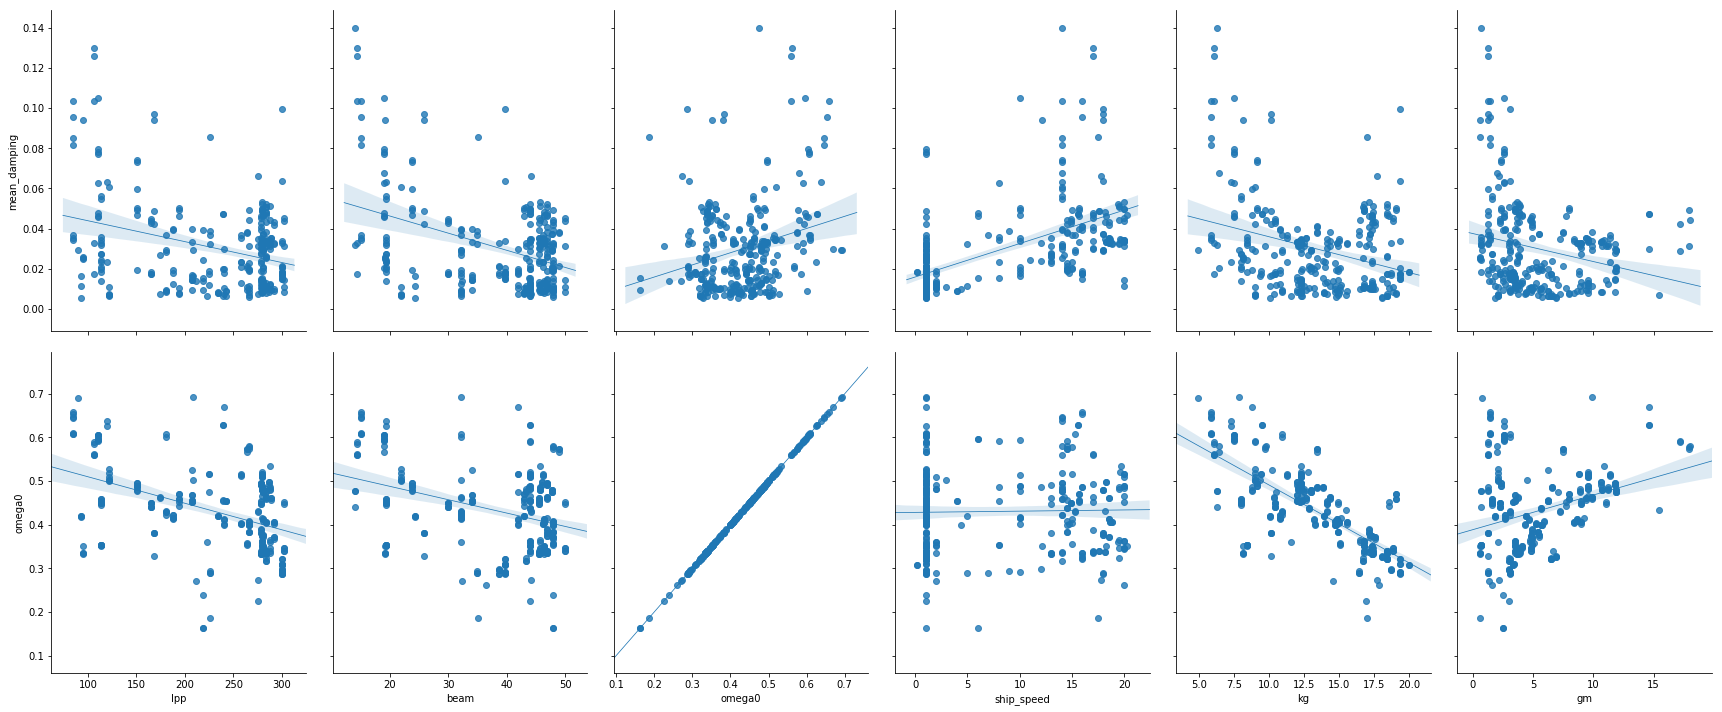

In [27]:
x_vars = ['lpp','beam','omega0','ship_speed','kg','gm']
sns.pairplot(df_rolldecay, x_vars=x_vars, y_vars=['mean_damping','omega0'],
             height=5, aspect=.8, kind="reg");

In [28]:
df_rolldecay.columns

Index(['d', 'mean_damping', 'omega0', 'score', 'zeta', 'id', 'project_number',
       'series_number', 'run_number', 'test_number', 'model_number',
       'ship_name', 'loading_condition_id', 'ascii_name', 'ship_speed',
       'comment', 'file_path_ascii', 'file_path_log', 'file_path_hdf5', 'date',
       'test_type', 'facility', 'angle1', 'angle2', 'name', 'lcg', 'kg', 'gm',
       'CW', 'TF', 'TA', 'BWL', 'KXX', 'KZZ', 'BTT1', 'CP', 'Volume', 'A0',
       'RH', 'scale_factor', 'lpp', 'beam', 'ABULB', 'BKX', 'TWIN', 'DCLR',
       'VDES', 'RHBL', 'ASKEG', 'PD', 'ARH', 'CFP', 'AIX', 'PDTDES', 'RTYPE',
       'SFP', 'BKL', 'BKB', 'PROT', 'D', 'LSKEG', 'RR', 'XSKEG', 'NDES', 'AR',
       'BR', 'BRA', 'IRUD', 'PTYPE', 'XRUD', 'AI', 'HSKEG', 'RSKEG', 'LOA',
       'ship_type_id'],
      dtype='object')

In [29]:
df_rolldecay.isnull().sum().sort_values(ascending=False)

angle2                  321
file_path_log           321
name                    321
CFP                     321
AIX                     321
ship_name               321
model_number            321
SFP                     321
ascii_name              321
comment                 321
PROT                    321
file_path_ascii         321
TWIN                    321
file_path_hdf5          321
date                    321
test_number             321
BR                      321
BRA                     321
PTYPE                   321
test_type               321
AI                      321
facility                321
angle1                  321
RR                      304
IRUD                    232
DCLR                    228
ARH                     211
ABULB                   193
RSKEG                   183
XRUD                    182
ship_type_id            180
XSKEG                   177
LSKEG                   171
BTT1                    170
HSKEG                   167
ASKEG               

In [30]:
important = ['KXX',                        
'BKL',                        
'BKX',                        
'RH',                         
'CW',                         
'CP',                         
'A0',                         
'LOA',                        
'AR',                         
'D',                          
'lpp',                        
'ship_speed',                 
'Volume',                     
'gm',                         
'TA',                         
'TF',                         
'beam',                       
'kg',                         
'lcg']                        
mask = df_rolldecay[important].notnull().all(axis=1)
df = df_rolldecay.loc[mask].copy()

In [31]:
data = df[important].copy()

In [32]:
df = df.dropna(subset=['omega0'])

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

polynomial_features = PolynomialFeatures(degree=3)
linear_regression = LinearRegression()
model = make_pipeline(polynomial_features, linear_regression)

X=data
y=df['omega0']

model.fit(X=X, y=y)
model.score(X=X, y=y)

0.9942803548110687

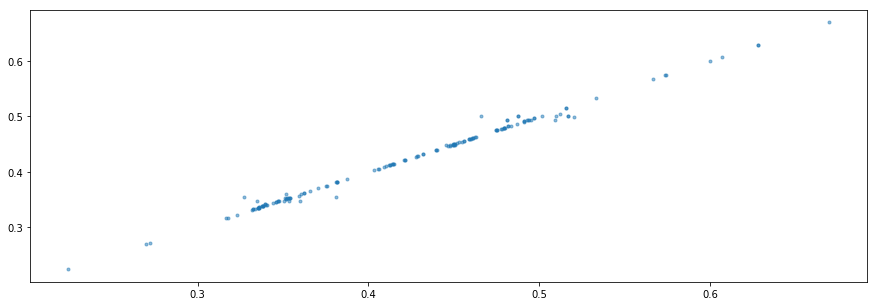

In [34]:
fig,ax = plt.subplots()
ax.plot(y,model.predict(X),'.', alpha=0.5)

Text(0, 0.5, 'Occurences [1]')

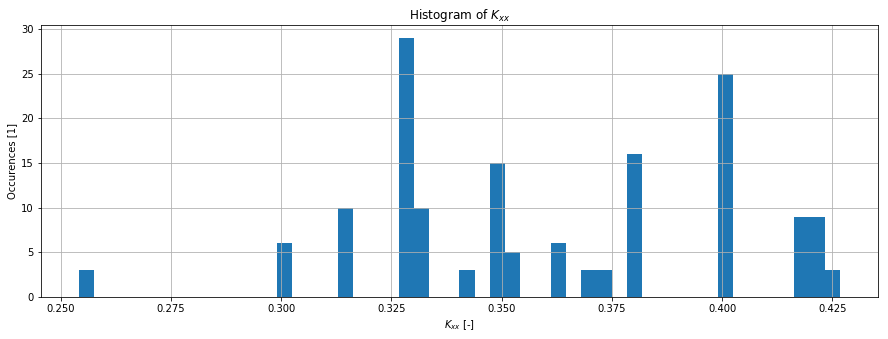

In [35]:
fig,ax=plt.subplots()
(data['KXX']/data['beam']).hist(bins=50, ax=ax)
ax.set_title('Histogram of $K_{xx}$')
ax.set_xlabel('$K_{xx}$ [-]');
ax.set_ylabel('Occurences [1]')

Text(0.5, 1.0, 'Added $r_{xx}$ ratio')

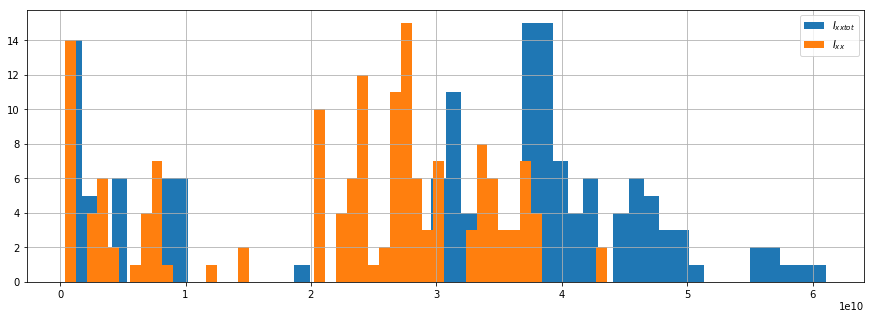

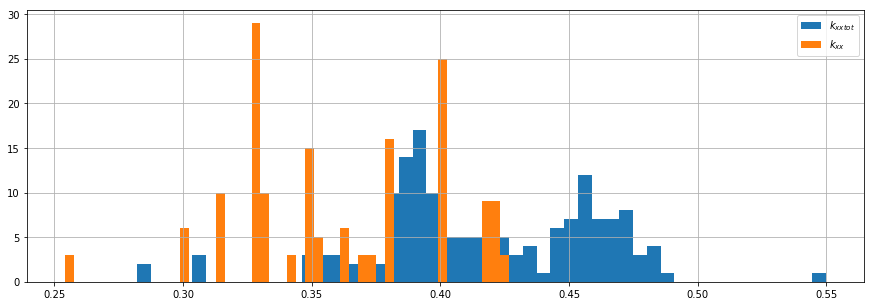

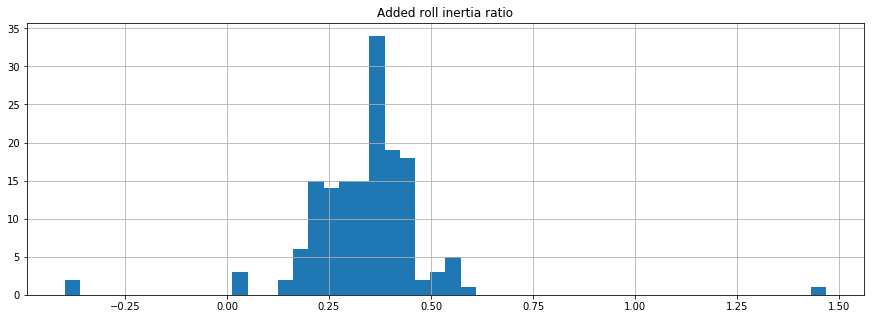

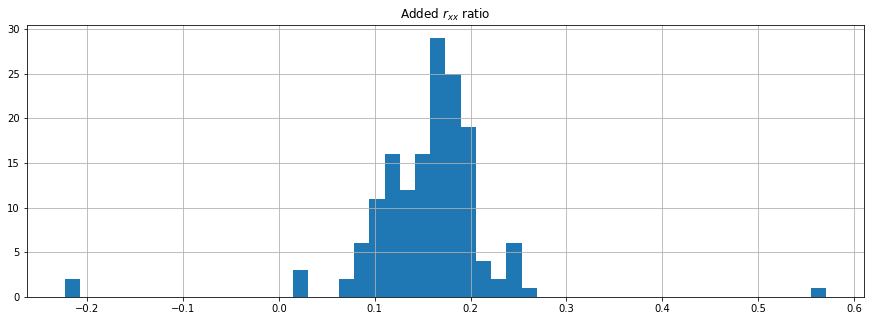

In [36]:
GM = df['gm']
beam = df['beam']
rxx = df['KXX']
kxx = rxx/beam
rho = 1000
m = rho*df['Volume']
Ixx = m*rxx**2
g = 9.81
omega0 = df['omega0']
Ixx_tot = GM*g*m/(omega0**2)
r_xx_tot = np.sqrt(Ixx_tot/m)
kxx_tot = r_xx_tot/beam

Ixx_added = Ixx_tot - Ixx
Ixx_added_ratio = Ixx_added/Ixx

rxx_added = r_xx_tot - rxx
rxx_added_ratio = rxx_added/rxx

fig,ax = plt.subplots()
Ixx_tot.hist(ax=ax, bins=50, label='$I_{xxtot}$')
Ixx.hist(ax=ax, bins=50, label='$I_{xx}$')
ax.legend()

fig,ax = plt.subplots()
kxx_tot.hist(ax=ax, bins=50, label='$k_{xxtot}$')
kxx.hist(ax=ax, bins=50, label='$k_{xx}$')
ax.legend()

fig,ax = plt.subplots()
Ixx_added_ratio.hist(ax=ax, bins=50)
ax.set_title('Added roll inertia ratio')

fig,ax = plt.subplots()
rxx_added_ratio.hist(ax=ax, bins=50)
ax.set_title('Added $r_{xx}$ ratio')


In [37]:
data.head()

,KXX,BKL,BKX,RH,CW,CP,A0,LOA,AR,D,lpp,ship_speed,Volume,gm,TA,TF,beam,kg,lcg
run_id,,,,,,,,,,,,,,,,,,,
59,9.01,58.70,0.0,5.8,0.833,0.7253,0.9862,181.45,18.4,5.4,167.68,1.0,26622.0,1.25,8.57,8.57,25.9,10.16,-1.63
64,9.01,58.70,0.0,5.8,0.833,0.7253,0.9862,181.45,18.4,5.4,167.68,18.0,26622.0,1.25,8.57,8.57,25.9,10.16,-1.63
65,9.01,58.70,0.0,5.8,0.833,0.7253,0.9862,181.45,18.4,5.4,167.68,18.0,26622.0,1.25,8.57,8.57,25.9,10.16,-1.63
254,9.01,58.70,0.0,5.8,0.833,0.7253,0.9862,181.45,18.4,5.4,167.68,1.0,26622.0,1.25,8.57,8.57,25.9,10.16,-1.63
572,16.50,80.94,-4.1,10.2,0.858,0.7714,0.9960,314.00,68.6,7.9,302.00,1.0,139566.0,4.82,12.00,12.00,50.0,18.84,-2.45


In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

polynomial_features = PolynomialFeatures(degree=3)
linear_regression = LinearRegression()
model = make_pipeline(polynomial_features, linear_regression)

X=data
y=df['mean_damping']

model.fit(X=X, y=y)
model.score(X=X, y=y)

0.9705839080703866

In [39]:
data.columns

Index(['KXX', 'BKL', 'BKX', 'RH', 'CW', 'CP', 'A0', 'LOA', 'AR', 'D', 'lpp',
       'ship_speed', 'Volume', 'gm', 'TA', 'TF', 'beam', 'kg', 'lcg'],
      dtype='object')